In [13]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import matplotlib.pyplot as plt

In [14]:
#PARAMETERS
N_QUBITS = 1000 # total qubits sent
ERROR_THRESHOLD = 0.10 # max acceptable QBER
NOISE_LEVELS = np.linspace(0, 0.15, 15)
print(f"Simulation Parameters:\nTotal Qubits: {N_QUBITS}\nQBER Abort Threshold: {ERROR_THRESHOLD}")

Simulation Parameters:
Total Qubits: 1000
QBER Abort Threshold: 0.1


In [16]:
def sent_by_alice():
    # we generate random bits and bases
    alice_bits = np.random.randint(2, size=N_QUBITS)
    # for bases, 0 corresponds to Z, 1 corresponds to X
    alice_bases = np.random.randint(2, size=N_QUBITS)
    
    qubits = [] #list that will append the N_QUBITS string

    for bit, basis in zip(alice_bits, alice_bases):
        qc = QuantumCircuit(1, 1) # 1 qubit, 1 classical bit
        # to make the independent choices thru code:
        # the default state is |0>. 
        # if "bit" == 0, we let it stay; else change it to |1> using X gate 
        if bit == 1:
            qc.x(0)
        # similarly if basis == 0; Z basis state ie it stays in |0> or |1>
        # if basis == 1, we apply hadamard to change it to |+> and |-> respt. in X basis
        if basis == 1:
            qc.h(0)
        qubits.append(qc)
        
    return qubits, alice_bits, alice_bases

In [17]:
# QBER Estimation and Detection

def estimate_qber(alice_key, bob_key):
    # calculates the QBER from a sample of the sifted key

    # first we select a small, random sample (10%)
    SAMPLE_SIZE = max(1, int(len(alice_key) * 0.1)) 
    # if the sifted key is too short, return 0 QBER ie no info
    if len(alice_key) == 0:
        return 0.0, 0

    sample_indices = np.random.choice(len(alice_key), SAMPLE_SIZE, replace=False)
    
    # compare the sampled bits
    mismatches = np.sum(alice_key[sample_indices] != bob_key[sample_indices])
    
    qber = mismatches / SAMPLE_SIZE
    final_key_length = len(alice_key) - SAMPLE_SIZE 
    
    return qber, final_key_length

def check_eavesdropping(qber, error_threshold):
    # determines if QBER is too high
    return qber <= error_threshold

In [18]:
# MAIN SIMULATION FUNCTION

def run_simulation(noise_level, N_qubits):
    """Runs the BB84 protocol for a given noise level"""

    # step 1: alice bits
    qubits, alice_bits, alice_bases = sent_by_alice()
    
    # step 2: noise model
    error = depolarizing_error(noise_level, 1)
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error, ['h', 'x'])
    # error will be applied following hadamard 'h' or NOT 'x' gate

    # step 3: measurement by bob
    circuits = []
    bob_bases = np.random.randint(2, size=N_qubits)
    for i in range(N_qubits):
        qc_bob = qubits[i].copy()
        if bob_bases[i] == 1: 
            # x basis measurement requires hadamard
            qc_bob.h(0)
        qc_bob.measure(0, 0)
        circuits.append(qc_bob)
    
    simulator = AerSimulator(noise_model=noise_model)
    transpiled_circuits = transpile(circuits, simulator)
    job = simulator.run(transpiled_circuits, shots=1)
    results = job.result().get_counts()
    
    # sep 4: extracting the measured bits
    bob_measured_bits = np.zeros(N_qubits, dtype=int)
    for i in range(N_qubits):
        # handle empty cases
        outcome = list(results[i].keys())[0] if results[i] else '0' 
        bob_measured_bits[i] = int(outcome)
    
    # step 5: SIFTING PROCESS
    sifted_mask = (alice_bases == bob_bases)
    
    alice_sifted_key = alice_bits[sifted_mask]
    bob_sifted_key = bob_measured_bits[sifted_mask]
    
    return alice_sifted_key, bob_sifted_key


--- Starting Simulation and Eavesdropping Detection ---
Noise 0.000: QBER 0.000 < Secure. Final Key Size: 448
Noise 0.011: QBER 0.020 < Secure. Final Key Size: 441
Noise 0.021: QBER 0.000 < Secure. Final Key Size: 455
Noise 0.032: QBER 0.000 < Secure. Final Key Size: 458
Noise 0.043: QBER 0.020 < Secure. Final Key Size: 457
Noise 0.054: QBER 0.083 < Secure. Final Key Size: 439
Noise 0.064: QBER 0.021 < Secure. Final Key Size: 424
Noise 0.075: QBER 0.020 < Secure. Final Key Size: 452
Noise 0.086: QBER 0.021 < Secure. Final Key Size: 428
Noise 0.096: QBER 0.038 < Secure. Final Key Size: 477
Noise 0.107: QBER 0.020 < Secure. Final Key Size: 443
Noise 0.118: QBER 0.020 < Secure. Final Key Size: 468
Noise 0.129: QBER 0.000 < Secure. Final Key Size: 445
Noise 0.139: QBER 0.083 < Secure. Final Key Size: 439
Noise 0.150: QBER 0.038 < Secure. Final Key Size: 468


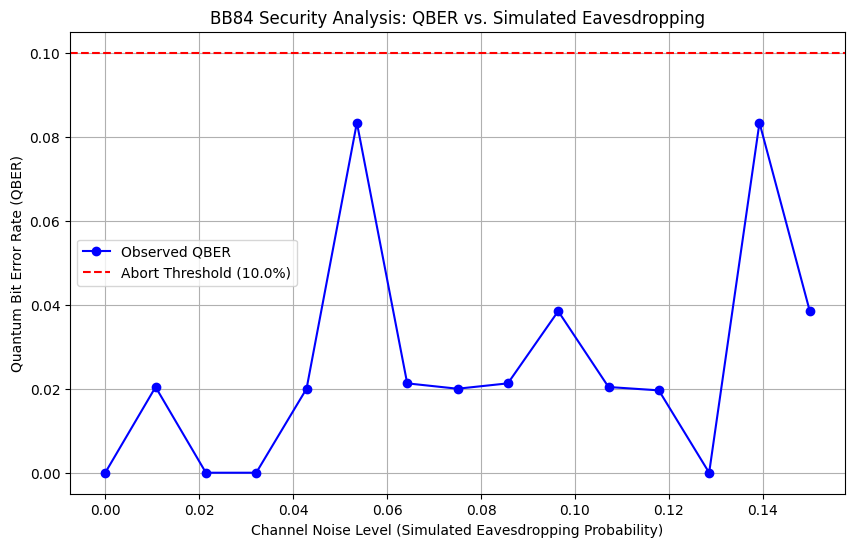

In [19]:
# FINAL EXECUTION

qbers = []
key_survival_status = [] 

print("\n--- Starting Simulation and Eavesdropping Detection ---")
for noise in NOISE_LEVELS:
    alice_sifted, bob_sifted = run_simulation(noise, N_QUBITS)
    qber, key_length = estimate_qber(alice_sifted, bob_sifted)
    qbers.append(qber)
    is_safe = check_eavesdropping(qber, ERROR_THRESHOLD)
    key_survival_status.append(is_safe)
    
    if not is_safe:
        print(f"Noise {noise:.3f}: QBER {qber:.3f} > ABORT. Eavesdropping Detected!")
    else:
        print(f"Noise {noise:.3f}: QBER {qber:.3f} < Secure. Final Key Size: {key_length}")

# VISUALIZATION

plt.figure(figsize=(10, 6))
plt.plot(NOISE_LEVELS, qbers, 'o-', color='blue', label='Observed QBER')
plt.axhline(y=ERROR_THRESHOLD, color='r', linestyle='--', label=f'Abort Threshold ({ERROR_THRESHOLD*100}%)')
plt.xlabel('Channel Noise Level (Simulated Eavesdropping Probability)')
plt.ylabel('Quantum Bit Error Rate (QBER)')
plt.title('BB84 Security Analysis: QBER vs. Simulated Eavesdropping')
plt.legend()
plt.grid(True)
plt.show() 